In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from collections import defaultdict
from typing import Dict

## Block 1

In [167]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"
#2022-12-14_10-50-49_Riesling_lip_e1_r1

#### Load file

In [168]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

In [169]:
# Selec trials in a block
n_block = 1
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
b_sp_samples = [sp_py['sp_samples'][i] for i in trial_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))

Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of clusters: 16


In [170]:
# sample identity
# IN:
# A: (1o 1c) 1 - 7
# B: (1o 5c) 8 - 14
# C: (5o 1c) 15 - 21
# D: (5o 5c) 22 - 28 

In [171]:
condition = np.arange(1,57)
samples_cond = {
    # samples IN
    'a_in' : np.arange(1,8),
    'b_in' : np.arange(8,15),
    'c_in' : np.arange(15,22),
    'd_in' : np.arange(22,29),
}

In [172]:
def test_stim(task,bhv_idx):
    for key,value in bhv_idx.items():
        if 'Stim_Filename_' in key:
            val = value.item(0).decode('utf-8')
            if key[-1] == 'd': # distractor
                task['test_stimuli_'+key[-2:]] += [val[-11:-4]]
            else:
                task['test_stimuli_'+key[-1]] += [val[-11:-4]]
                n_test =  int(key[-1])

    for n in range(n_test+1,6):
        task['test_stimuli_'+str(n)] += ['']
        task['test_stimuli_'+str(n)+'d'] += ['']

    return task,n_test

In [173]:
def create_task_frame(trial_idx,bhv,samples_cond):
    task:Dict[str,list] = defaultdict(list)#{}
    for idx in trial_idx:
        task['idx_trial'] += [idx]
        cond = int(bhv[idx]['Condition'][0][0])
        a_out = samples_cond['a_in']+28
        b_out = samples_cond['b_in']+28
        c_out = samples_cond['c_in']+28
        d_out = samples_cond['d_in']+28
        # IN
        if cond in samples_cond['a_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['A']
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['a_in'][-1]-cond)]
        elif cond in samples_cond['b_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['B']
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['b_in'][-1]-cond)]
        elif cond in samples_cond['c_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['C']
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['c_in'][-1]-cond)]
        elif cond in samples_cond['d_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['D']
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['d_in'][-1]-cond)]
        # OUT
        elif cond in a_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['A']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (a_out[-1]-cond)]
        elif cond in b_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['B']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (b_out[-1]-cond)]
        elif cond in c_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['C']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (c_out[-1]-cond)]
        elif cond in d_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['D']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (d_out[-1]-cond)]

    return pd.DataFrame(task)

In [174]:
task=create_task_frame(trial_idx,bhv,samples_cond)

In [175]:
stim_codes = {'A':'o_1_c_1','B':'o_1_c_5','C':'o_5_c_1','D':'o_5_c_5'}

In [180]:
# kernel parameters
fs = 1000
w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms

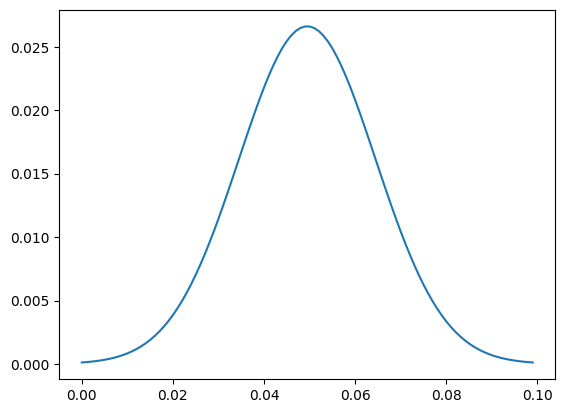

In [181]:
# define kernel for the convolution
kernel = signal.gaussian(M=w_size*fs,std=w*fs)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs,kernel)

In [182]:
events = {
    'fixation':8,
    'sample_on': 23,
    'sample_off': 24,
    'test_on_1': 25, 
    'test_off_1':26,
    # 'test_on_2': 27, 
    # 'test_off_2':28,
    # 'test_on_3': 29, 
    # 'test_off_3':30,
    # 'test_on_4': 31, 
    # 'test_off_4':32,
    # 'test_on_5': 33, 
    # 'test_off_5':34,
}

In [183]:
x_lim_max = 1.5
x_lim_min = -0.7
neurons = np.where(sp_py['clustersgroup']=='good')[0]
n_test_stim = 2
code = 2
in_out=1
down_sample=30

In [209]:
stim

'B'

In [214]:
task[(task['sample_id']=='A') & (task['in_out']==in_out) & (task['code']==7) & (task['test_stimuli_1']==stim_codes['D'])]

,idx_trial,test_stimuli_1,test_stimuli_1d,test_stimuli_2,test_stimuli_2d,test_stimuli_3,test_stimuli_3d,test_stimuli_4,test_stimuli_4d,test_stimuli_5,test_stimuli_5d,sample_id,in_out,n_test_stimuli,code
88,323,o_5_c_5,o_4_c_7,o_1_c_8,o_8_c_1,o_8_c_1,o_4_c_8,o_5_c_5,o_5_c_4,o_8_c_1,o_1_c_5,A,1,5,7
505,1187,o_5_c_5,o_4_c_2,o_1_c_3,o_6_c_2,o_5_c_5,o_1_c_5,o_3_c_1,o_5_c_4,o_1_c_5,o_1_c_4,A,1,5,7
513,1211,o_5_c_5,o_4_c_1,o_8_c_1,o_4_c_5,o_2_c_8,o_1_c_2,o_8_c_6,o_3_c_6,o_7_c_4,o_8_c_8,A,1,5,7


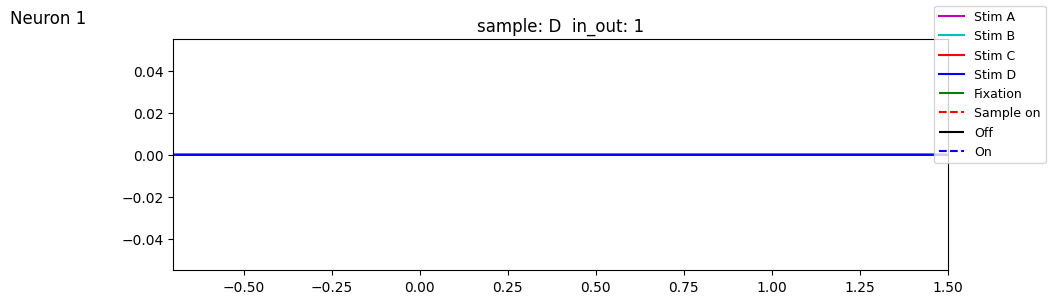

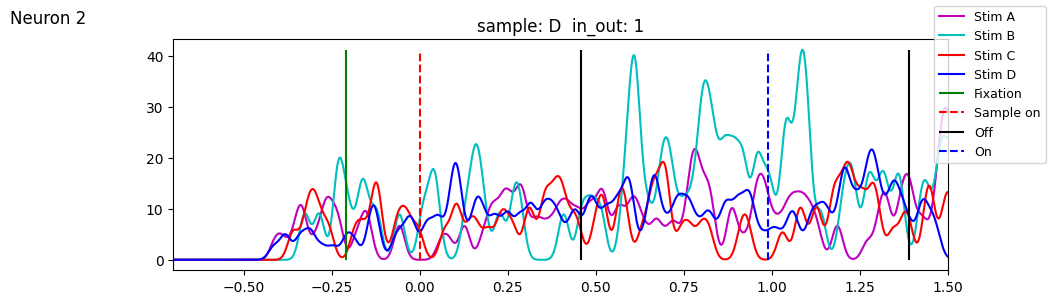

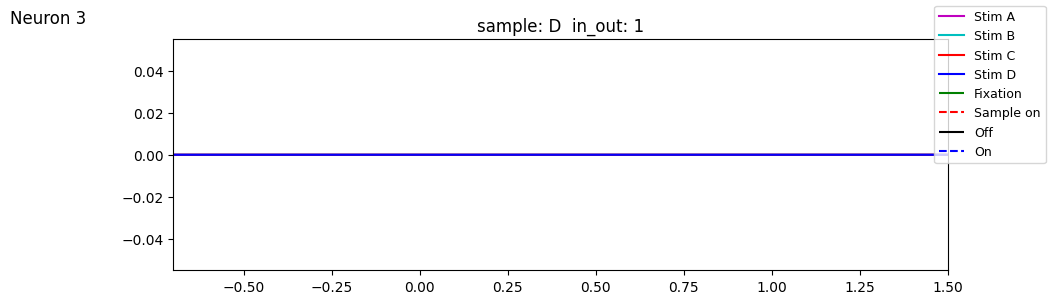

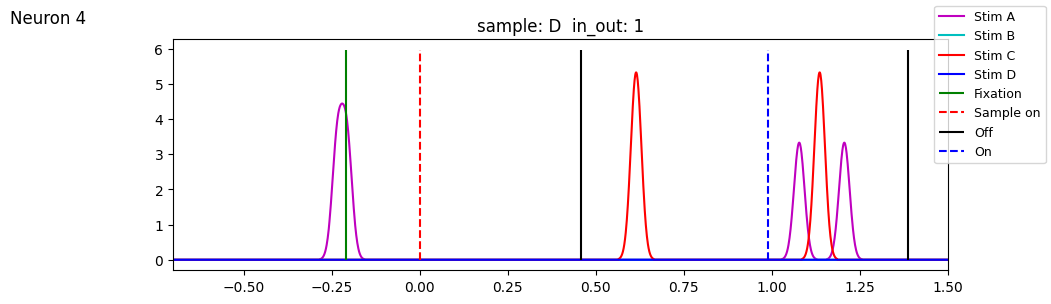

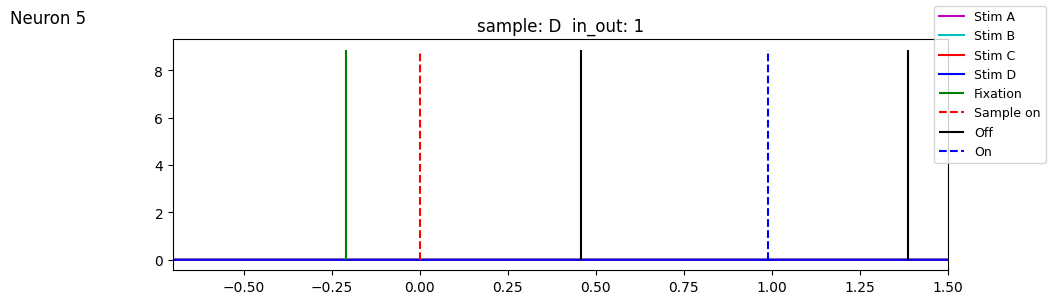

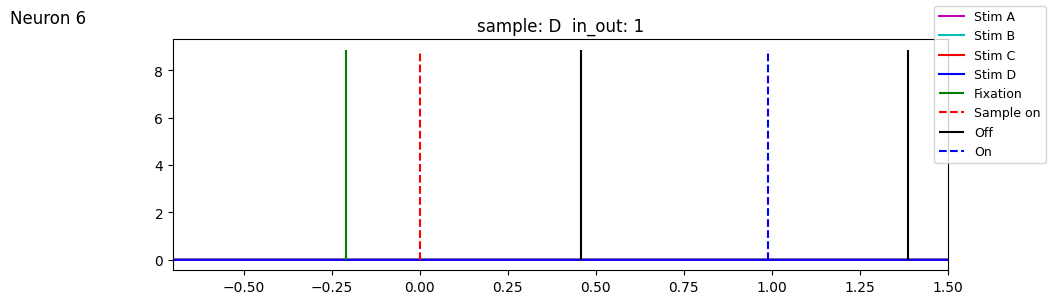

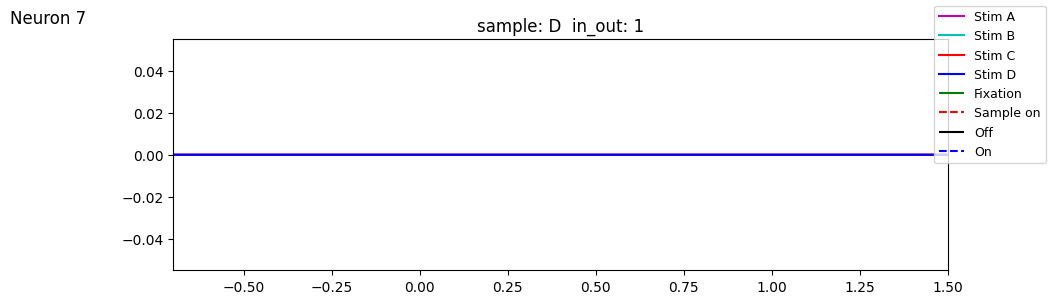

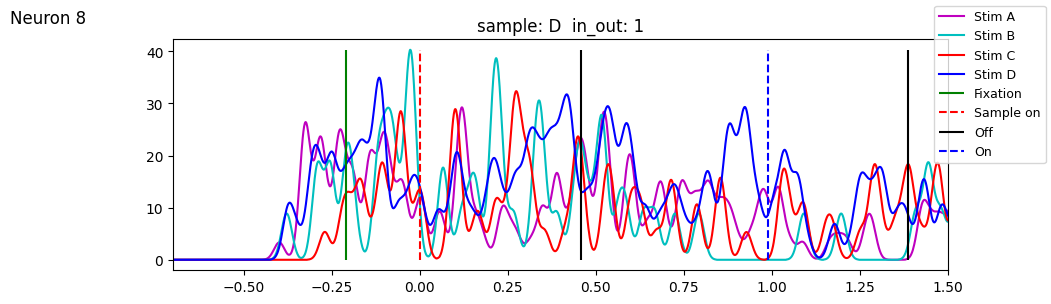

In [216]:

#def get_mean_fr(task,events,neurons,code,n_test_stim,in_out,x_lim_min,x_lim_max,down_sample,sp_py):
total_events_timestamps = np.zeros((1,len(events))) #np.zeros((1,(n_test_stim*2)+3))
mean_fr:Dict[str,list] = defaultdict(list)
for i,neuron in enumerate(neurons):
    conv_max=0
    fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
    for color,sample,stim in zip(['m','c','r','b'],['D','D','D','D'],['A','B','C','D']):
        target_trials_idx = task[(task['sample_id']==sample) & (task['in_out']==in_out) & (task['n_test_stimuli']<7) & (task['test_stimuli_1']==stim_codes[stim])]['idx_trial'].values
        events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,1]) 
        shift_events = (events_timestamps.T-events_timestamps.T[1]).T
        total_events_timestamps = np.concatenate((total_events_timestamps,shift_events))
        if len(neuron_trials[0]) != 0:
            # Compute trial average fr
            trial_average_sp,sorted_sp_neuron = firing_rate.trial_average_fr(neuron_trials)
            # 
            if sorted_sp_neuron[0]> x_lim_min*fs*down_sample:
                add_zeros = np.zeros(int(sorted_sp_neuron[0]-(x_lim_min*fs*down_sample)))
                trial_average_sp = np.concatenate((add_zeros,trial_average_sp))
            else: 
                trial_average_sp = trial_average_sp[int(abs(x_lim_min*fs*down_sample)):]
            # Downsample to 1ms
            trial_average_sp =np.sum(np.concatenate((trial_average_sp,np.zeros(down_sample-len(trial_average_sp)%down_sample))).reshape(-1,down_sample),axis=1)
            
        else:
            trial_average_sp=[0]*int((x_lim_max-x_lim_min)*fs)#round(np.max(shift_events[:,-1])/down_sample)
            sorted_sp_neuron=[int(x_lim_min*fs*down_sample)]#round(np.max(shift_events[:,-1])/down_sample)

            
        conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
        conv_max=conv_max if conv_max > max(conv) else max(conv)
        # add values to dict
        ev = np.floor(np.mean(shift_events,axis=0)/down_sample)
        ev_a = np.zeros(len(conv))
        #ev_a[ev.tolist()]=1
        mean_fr['neuron'] += [neuron + 1] * len(conv)
        mean_fr['conv'] += conv.tolist()
        mean_fr['mean_idx_events'] += ev_a.tolist()
        mean_fr['sample'] += [sample] * len(conv)
        mean_fr['n_test_stimuli'] += [n_test_stim] * len(conv)
        # plot
        ax.plot((np.arange(len(trial_average_sp)) + x_lim_min*fs) / fs, conv,color)

    mean_idx_events = total_events_timestamps[1:].mean(axis=0)/down_sample
    ax.vlines(mean_idx_events[0]/fs, 0, conv_max ,color="g", linestyles="solid")
    ax.vlines(mean_idx_events[1]/fs, 0, conv_max ,color="r", linestyles="dashed")
    ax.vlines(mean_idx_events[2]/fs, 0, conv_max ,color="k", linestyles="solid")
    for n in range(3,len(events),2):
        ax.vlines(mean_idx_events[n]/fs, 0, conv_max ,color="b", linestyles="dashed")
        ax.vlines(mean_idx_events[n+1]/fs, 0, conv_max ,color="k", linestyles="solid")
    
    ax.set_title('sample: %s  in_out: %d'%(sample,in_out))
    ax.set_xlim(x_lim_min, x_lim_max)
    fig.legend(['Stim A','Stim B','Stim C','Stim D','Fixation','Sample on','Off','On'], fontsize=9)
    fig.suptitle("Neuron %d" % (i + 1), x=0)
    plt.show()
mean_fr=pd.DataFrame(mean_fr)


In [38]:
mean_fr_neutral[(mean_fr_neutral['neuron']==1) & (mean_fr_neutral['sample']=='B')]

,neuron,conv,mean_idx_events,sample,n_test_stimuli
3579,1,1.209280,1.0,B,5
3580,1,1.209280,0.0,B,5
3581,1,1.203917,0.0,B,5
3582,1,1.193263,0.0,B,5
3583,1,1.177459,0.0,B,5
...,...,...,...,...,...
10221,1,1.272424,0.0,B,5
10222,1,1.277386,0.0,B,5
10223,1,1.279176,0.0,B,5
10224,1,1.277454,0.0,B,5


In [39]:
mean_fr[(mean_fr['neuron']==1) & (mean_fr['sample']=='B')]

,neuron,conv,mean_idx_events,sample,n_test_stimuli
3948,1,1.064166,1.0,B,2
3949,1,1.064166,0.0,B,2
3950,1,1.059447,0.0,B,2
3951,1,1.050072,0.0,B,2
3952,1,1.036164,0.0,B,2
...,...,...,...,...,...
8121,1,1.937104,0.0,B,2
8122,1,1.887335,0.0,B,2
8123,1,1.835384,0.0,B,2
8124,1,1.781331,0.0,B,2
